# QLoRA (Quantized Low-Rank Adaption)

En este cuadernillo implementarmos QLoRA a un modelo conocido como ``vit_b_16`` pretence a los ViT que es un modelo de red neuronal basada en transformadores, pero aplicada a imágenes en lugar de texto.

## Importacion de librerias

En esta parte importamos todas las librerias necesarias para trabajar con QLoRA

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from tqdm import tqdm
import bitsandbytes as bnb
import torch
from torch.utils.data import DataLoader
import math
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

## Carga y Preprocesamiento de Datos

En esta sección se preparan los datos de imágenes para entrenar el modelo ViT con LoRA.

### **Transformaciones de Imágenes**

In [ ]:
# Preparación de los datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_path = r"D:\Ciencias\Dataset Residuos solidos\data\train"
val_path = r"D:\Ciencias\Dataset Residuos solidos\data\val"

train_dataset = datasets.ImageFolder(root=train_path, transform=transform) # Carga del conjunto de datos de entrenamiento
val_dataset = datasets.ImageFolder(root=val_path, transform=transform) # Carga del conjunto de datos de validación

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2) # Carga de datos de entrenamiento
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2) # Carga de datos de validación

### **Selección aleatoria de índices**

Este código selecciona y muestra 5 imágenes aleatorias del conjunto de entrenamiento para inspeccionar visualmente los datos.

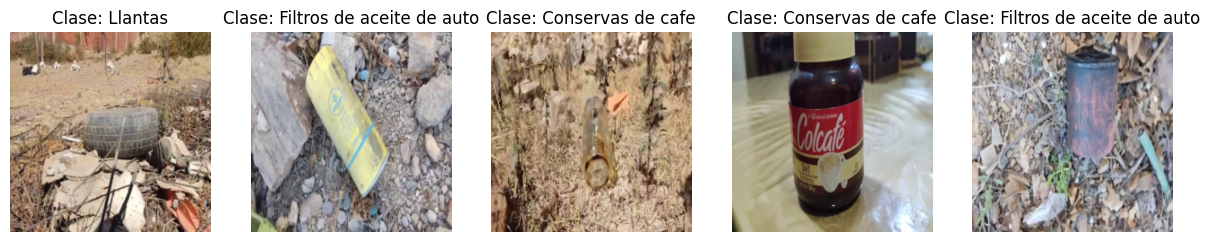

In [3]:
# Mostrar algunas imágenes
indices = random.sample(range(len(train_dataset)), 5)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    image, label = train_dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Clase: {train_dataset.classes[label]}")
    plt.axis('off')
plt.show()

## Implementación de la Clase QLoRALinear

La clase `QLoRALinear` implementa la técnica **QLoRA (Quantized Low-Rank Adaptation)**,  
una extensión de **LoRA** diseñada para entrenar **modelos cuantizados** (por ejemplo, en 4 bits) de forma **eficiente y estable**.

Este método permite **fine-tuning de grandes modelos** en GPUs de consumo, reduciendo el uso de memoria sin sacrificar precisión.

---

### Fundamento Teórico

En una capa lineal tradicional:

\[
y = xW + b
\]

donde:
- $x \in \mathbb{R}^{B \times d}$: entrada
- $W \in \mathbb{R}^{d \times k}$: pesos de la capa
- $b$: sesgo
- $y \in \mathbb{R}^{B \times k}$: salida

---

### Adaptación LoRA

LoRA introduce una actualización de bajo rango a los pesos:
## Implementación de la Clase QLoRALinear

La clase `QLoRALinear` implementa la técnica **QLoRA (Quantized Low-Rank Adaptation)**,  
una extensión de **LoRA** diseñada para entrenar **modelos cuantizados** (por ejemplo, en 4 bits) de forma **eficiente y estable**.

Este método permite **fine-tuning de grandes modelos** en GPUs de consumo, reduciendo el uso de memoria sin sacrificar precisión.

---

### Fundamento Teórico

En una capa lineal tradicional:

$$
y = xW + b
$$

donde:
- $x \in \mathbb{R}^{B \times d}$: entrada
- $W \in \mathbb{R}^{d \times k}$: pesos de la capa
- $b$: sesgo
- $y \in \mathbb{R}^{B \times k}$: salida

---

### Adaptación LoRA

LoRA introduce una actualización de bajo rango a los pesos:

$$
W' = W + \Delta W \quad \text{con} \quad \Delta W = BA
$$

donde:

- $A \in \mathbb{R}^{r \times d}$
- $B \in \mathbb{R}^{k \times r}$
- $r \ll \min(d, k)$

y el cálculo de salida se convierte en:

$$
y = xW + (xA^TB^T) \cdot \frac{\alpha}{r}
$$

---

### Extensión QLoRA

**QLoRA** aplica LoRA sobre **pesos cuantizados**.  
En lugar de almacenar los pesos $W$ en precisión completa (FP32 o FP16), los convierte a una representación **de baja precisión (4 bits)** mediante cuantización **NF4** (*Normal Float 4*).

Esto se logra con ayuda del módulo `bitsandbytes`, que implementa capas como `Linear4bit`:

$$
\tilde{W} = Q_4(W)
$$

donde $Q_4$ representa la cuantización en 4 bits.  
Durante el entrenamiento, solo las matrices LoRA $A$ y $B$ se ajustan, mientras que $\tilde{W}$ permanece congelado.

---

### Cálculo en la Implementación

El método `forward` de `QLoRALinear` se define como:

$$
y = \text{QuantLinear}(x) + \left(x A^T B^T\right) \cdot \frac{\alpha}{r}
$$

donde:
- `QuantLinear` representa la capa base cuantizada (no entrenable).
- $A$ y $B$ son las matrices LoRA entrenables.
- $\frac{\alpha}{r}$ actúa como un factor de escala para estabilizar los gradientes.

donde:
- $A \in \mathbb{R}^{r \times d}$
- $B \in \mathbb{R}^{k \times r}$
- $r \ll \min(d, k)$

y el cálculo de salida se convierte en:

$$
y = xW + (xA^TB^T) \cdot \frac{\alpha}{r}
$$

---

##E Extensión QLoRA

**QLoRA** aplica LoRA sobre **pesos cuantizados**.  
En lugar de almacenar los pesos \( W \) en precisión completa (FP32 o FP16), los convierte a una representación **de baja precisión (4 bits)** mediante cuantización **NF4** (*Normal Float 4*).

Esto se logra con ayuda del módulo `bitsandbytes`, que implementa capas como `Linear4bit`:

$$
\tilde{W} = Q_4(W)
$$

donde \( Q_4 \) representa la cuantización en 4 bits.  
Durante el entrenamiento, solo las matrices LoRA \( A \) y \( B \) se ajustan, mientras que \( \tilde{W} \) permanece congelado.

---

### Cálculo en la Implementación

El método `forward` de `QLoRALinear` se define como:

$$
y = \text{QuantLinear}(x) + \left(x A^T B^T\right) \cdot \frac{\alpha}{r}
$$

donde:
- `QuantLinear` representa la capa base cuantizada (no entrenable).
- $A$ y $B$ son las matrices LoRA entrenables.
- $\frac{\alpha}{r}$ actúa como un factor de escala para estabilizar los gradientes.

---


In [ ]:
class QLoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=8, quant_bits=4, bias=True):
        super().__init__()
        self.in_features = in_features # Número de características de entrada
        self.out_features = out_features # Número de características de salida
        self.r = r # Dimensión de los adaptadores LoRA
        self.alpha = alpha # Factor de escalado para LoRA
        self.scaling = alpha / r # Factor de escalado

        # Capa cuantizada base usando bitsandbytes, en 4 bits
        self.quant_linear = bnb.nn.Linear4bit(
            in_features, 
            out_features,
            bias=bias,
            quant_type="nf4",
            compute_dtype=torch.float16 # Tipo de dato para cálculos
        )
        
        # Parámetros LoRA
        self.lora_A = nn.Parameter(torch.zeros(r, in_features)) # Matriz A de LoRA  
        self.lora_B = nn.Parameter(torch.zeros(out_features, r)) # Matriz B de LoRA

        nn.init.kaiming_uniform_(self.lora_A, a=5**0.5) # Inicialización de A
        nn.init.zeros_(self.lora_B) # Inicialización de B
    
    def forward(self, x): # Propagación hacia adelante
        base_output = self.quant_linear(x) # Salida de la capa cuantizada base
        lora_output = (x @ self.lora_A.t() @ self.lora_B.t()) * self.scaling # Salida de LoRA
        return base_output + lora_output # Suma de ambas salidas

### Funcion para cargar el Modelo con 5 clases

Esta funcion carga el modelo con 5 clases usando el modelo VIT con pesos preentrenados, esto tomando en cuenta que congealmos todo el modelo

In [ ]:
def setup_model_for_5_classes(r=4, alpha=8):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Usando dispositivo: {device}")
    
    # Cargar modelo base CON pesos preentrenados
    model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
    
    # CONGELAR todo el modelo base
    for param in model.parameters():
        param.requires_grad = False
    
    # Reemplazar la cabeza para 5 clases usando QLoRA
    num_classes = 5
    model.heads.head = QLoRALinear(
        in_features=768, 
        out_features=num_classes,
        r=r, 
        alpha=alpha, 
        quant_bits=4
    )
    
    # Hacer que solo los parámetros LoRA sean entrenables
    for name, param in model.named_parameters():
        if 'lora' in name:
            param.requires_grad = True # Entrenable
        else:
            param.requires_grad = False # Congelado
    
    model = model.to(device)
    
    # Verificar parámetros
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"✅ Modelo configurado para {num_classes} clases")
    print(f"📊 Parámetros totales: {total_params:,}")
    print(f"📊 Parámetros entrenables: {trainable_params:,}")
    print(f"📊 Porcentaje entrenable: {100*trainable_params/total_params:.4f}%")
    
    return model, device

In [ ]:
def train_qlora_final():
    # Usar los mismos hiperparámetros que para guardar
    model, device = setup_model_for_5_classes(r=4, alpha=8)

    num_epochs = 3
    optimizer = bnb.optim.Adam8bit(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=1e-3
    )

    for epoch in range(num_epochs):
        # ----------- Entrenamiento -----------
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        loop = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}", leave=True)
        
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=100*correct_train/total_train)
        
        train_loss = total_train_loss / len(train_loader)
        train_acc  = 100 * correct_train / total_train
        
        # ----------- Validación -----------
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                total_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        val_loss = total_val_loss / len(val_loader)
        val_acc  = 100 * correct_val / total_val
        
        print(f"📊 Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return model, device

In [7]:
def save_qlora_model(model, path="modelo_completo_qlora.pt"):
    """Guardar SOLO los parámetros LoRA, no toda la capa cuantificada"""
    # Guardar solo los parámetros LoRA y el estado del modelo
    save_dict = {
        'lora_A': model.heads.head.lora_A.data,
        'lora_B': model.heads.head.lora_B.data,
        'model_state': model.state_dict(),  # Para compatibilidad
        'r': model.heads.head.r,
        'alpha': model.heads.head.alpha,
        'scaling': model.heads.head.scaling
    }
    
    torch.save(save_dict, path)
    print(f"✅ Parámetros LoRA guardados en {path}")

## Funcion de carga del modelo entrenado con QLoRA

Creamos la funcion para cargar el modelo entrenado con QLoRA, respetando la arquitectura usada para entrenar el modelo con QLoRA

In [ ]:
def load_qlora_model(model_path="modelo_completo_qlora.pt"):
    """Cargar modelo con parámetros LoRA"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Cargando modelo en {device}...")
    
    # Primero cargar los parámetros guardados
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Crear modelo base
    model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
    
    # Configurar la cabeza QLoRA con los mismos parámetros
    r = checkpoint.get('r', 4)
    alpha = checkpoint.get('alpha', 8)
    
    num_classes = 5
    model.heads.head = QLoRALinear(
        in_features=768, 
        out_features=num_classes,
        r=r, 
        alpha=alpha, 
        quant_bits=4
    )
    
    # Cargar parámetros LoRA
    model.heads.head.lora_A.data = checkpoint['lora_A']
    model.heads.head.lora_B.data = checkpoint['lora_B']
    
    # Congelar todo excepto LoRA
    for param in model.parameters():
        param.requires_grad = False
    
    # Hacer que solo los parámetros LoRA sean entrenables
    for name, param in model.named_parameters():
        if 'lora' in name:
            param.requires_grad = True

    # Mover el modelo al dispositivo
    model = model.to(device)
    model.eval()
    
    print("✅ Modelo QLoRA cargado correctamente")
    print(f"📊 Parámetros LoRA: r={r}, alpha={alpha}")
    
    return model, device

## Entrenamiento del Modelo

In [9]:
print("🚀 ENTRENANDO QLoRA PARA 5 CLASES...")
model, device = train_qlora_final()

🚀 ENTRENANDO QLoRA PARA 5 CLASES...
🚀 Usando dispositivo: cuda
✅ Modelo configurado para 5 clases
📊 Parámetros totales: 85,803,673
📊 Parámetros entrenables: 3,092
📊 Porcentaje entrenable: 0.0036%


Train Epoch 1/3: 100%|██████████| 2501/2501 [10:32<00:00,  3.95it/s, acc=97.9, loss=0.000571]


📊 Epoch 1/3 | Train Loss: 0.0647, Train Acc: 97.94% | Val Loss: 0.0020, Val Acc: 99.95%


Train Epoch 2/3: 100%|██████████| 2501/2501 [10:33<00:00,  3.95it/s, acc=100, loss=0.000129]


📊 Epoch 2/3 | Train Loss: 0.0010, Train Acc: 99.99% | Val Loss: 0.0007, Val Acc: 100.00%


Train Epoch 3/3: 100%|██████████| 2501/2501 [10:34<00:00,  3.94it/s, acc=100, loss=0.000177]


📊 Epoch 3/3 | Train Loss: 0.0009, Train Acc: 99.99% | Val Loss: 0.0004, Val Acc: 100.00%


In [10]:
# Guardar el modelo
save_qlora_model(model, "modelo_completo_qlora.pt")

✅ Parámetros LoRA guardados en modelo_completo_qlora.pt


In [11]:
# Función de predicción (sin cambios)
def predict_image(image_path, model, device, class_names):
    from PIL import Image
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Mostrar imagen
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    # Predicción
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, pred = torch.max(probabilities, 1)
    
    print(f"💡 Predicción: {class_names[pred.item()]}")
    print(f"📊 Confianza: {confidence.item():.2%}")
    
    return class_names[pred.item()]


## Prueba del Modelo entrenado con LoRA

Aqui cargamos el mismo modelo preentrenado, luego reemplamos la cabeza con la misma estructura del entranmiento el cuaal contiene 5 clases, luego cargamos los pesos entrenados:

In [12]:
print("🔧 CARGANDO MODELO PARA PREDICCIÓN...")
model_qlora, device = load_qlora_model("modelo_completo_qlora.pt")

🔧 CARGANDO MODELO PARA PREDICCIÓN...
🚀 Cargando modelo en cuda...
✅ Modelo QLoRA cargado correctamente
📊 Parámetros LoRA: r=4, alpha=8


### Prediccion de una Imagen

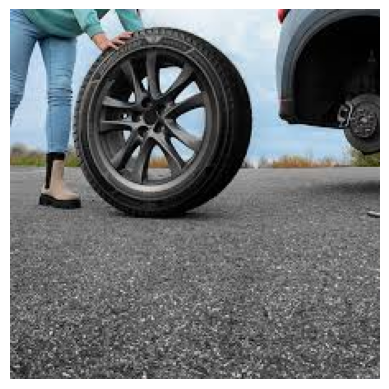

💡 Predicción: Llantas
📊 Confianza: 99.96%


'Llantas'

In [14]:
image_path = r"D:\Downloads\images.jpeg"
class_names = train_dataset.classes
predict_image(image_path, model_qlora, device, class_names)